In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
path = "../data/"
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [3]:
objp = np.zeros((9 * 6, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

In [4]:
img_ptsL = []
img_ptsR = []
obj_pts = []

In [5]:
a = cv2.imread("../data/LeftImage_2.jpg")
a.shape

(480, 640, 3)

In [6]:
for i in tqdm(range(1, 42)):
    imgL = cv2.imread(path + "LeftImage_%d.jpg" % i)
    imgR = cv2.imread(path + "RightImage_%d.jpg" % i)
    imgL_gray = cv2.imread(path + "LeftImage_%d.jpg" % i, 0)
    imgR_gray = cv2.imread(path + "RightImage_%d.jpg" % i, 0)

    outputL = imgL.copy()
    outputR = imgR.copy()

    retR, cornersR = cv2.findChessboardCorners(outputR, (9, 6), None)
    retL, cornersL = cv2.findChessboardCorners(outputL, (9, 6), None)

    if retR and retL:
        obj_pts.append(objp)
        cv2.cornerSubPix(imgR_gray, cornersR, (11, 11), (-1, -1), criteria)
        cv2.cornerSubPix(imgL_gray, cornersL, (11, 11), (-1, -1), criteria)
        cv2.drawChessboardCorners(outputR, (9, 6), cornersR, retR)
        cv2.drawChessboardCorners(outputL, (9, 6), cornersL, retL)
        # cv2.imshow('cornersR', outputR)
        # cv2.imshow('cornersL', outputL)
        # cv2.waitKey(0)
        img_ptsL.append(cornersL)
        img_ptsR.append(cornersR)
cv2.destroyAllWindows()

100%|██████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 14.99it/s]


In [7]:
# Calibrating left camera
retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(obj_pts, img_ptsL, imgL_gray.shape[::-1], None, None)
hL, wL = imgL_gray.shape[:2]
new_mtxL, roiL = cv2.getOptimalNewCameraMatrix(mtxL, distL, (wL, hL), 1, (wL, hL))
# Calibrating right camera
retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(obj_pts, img_ptsR, imgR_gray.shape[::-1], None, None)
hR, wR = imgR_gray.shape[:2]
new_mtxR, roiR = cv2.getOptimalNewCameraMatrix(mtxR, distR, (wR, hR), 1, (wR, hR))
print(retL, retR)

1.071538941482059 1.1278666673821118


In [8]:
flags = 0
flags |= cv2.CALIB_FIX_INTRINSIC
# Here we fix the intrinsic camara matrixes so that only Rot, Trns, Emat and Fmat are calculated.
# Hence intrinsic parameters are the same
criteria_stereo= (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# This step is performed to transformation between the two cameras and calculate Essential and Fundamenatl matrix
retS, new_mtxSL, distSL, new_mtxSR, distSR, Rot, Trns, Emat, Fmat = cv2.stereoCalibrate(obj_pts, img_ptsL, img_ptsR, new_mtxL, distL, new_mtxR, distR, imgL_gray.shape[::-1], criteria_stereo, flags)

In [9]:
retS

3.3712688865394185

In [10]:
Emat, Fmat

(array([[-0.01488133, -1.40911493, -0.06020201],
        [ 1.54039391, -0.25518196, -4.04562231],
        [ 0.19872378,  4.09418954, -0.23163266]]),
 array([[ 1.98948073e-07,  1.89039082e-05, -4.01947319e-03],
        [-2.05997945e-05,  3.42442985e-06,  2.84278146e-02],
        [ 3.77542936e-03, -3.20303182e-02,  1.00000000e+00]]))

In [11]:
rectify_scale= 1
rect_l, rect_r, proj_mat_l, proj_mat_r, Q, roiSL, roiSR= cv2.stereoRectify(new_mtxSL, distSL, new_mtxSR, distSR, imgL_gray.shape[::-1], Rot, Trns, rectify_scale,(0,0))


In [12]:
Left_Stereo_Map= cv2.initUndistortRectifyMap(new_mtxSL, distSL, rect_l, proj_mat_l,
                                             imgL_gray.shape[::-1], cv2.CV_16SC2)
Right_Stereo_Map= cv2.initUndistortRectifyMap(new_mtxSR, distSR, rect_r, proj_mat_r,
                                              imgR_gray.shape[::-1], cv2.CV_16SC2)

print("Saving parameters ......")
cv_file = cv2.FileStorage("improved_params2.xml", cv2.FILE_STORAGE_WRITE)
cv_file.write("Left_Stereo_Map_x",Left_Stereo_Map[0]q)
cv_file.write("Left_Stereo_Map_y",Left_Stereo_Map[1])
cv_file.write("Right_Stereo_Map_x",Right_Stereo_Map[0])
cv_file.write("Right_Stereo_Map_y",Right_Stereo_Map[1])
cv_file.release()


Saving parameters ......


In [13]:
cv2.imshow("Left image before rectification", imgL)
cv2.imshow("Right image before rectification", imgR)

Left_nice= cv2.remap(imgL,Left_Stereo_Map[0],Left_Stereo_Map[1], cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
Right_nice= cv2.remap(imgR,Right_Stereo_Map[0],Right_Stereo_Map[1], cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)

cv2.imshow("Left image after rectification", Left_nice)
cv2.imshow("Right image after rectification", Right_nice)
cv2.waitKey(0)

out = Right_nice.copy()
out[:,:,0] = Right_nice[:,:,0]
out[:,:,1] = Right_nice[:,:,1]
out[:,:,2] = Left_nice[:,:,2]

cv2.imshow("Output image", out)
cv2.waitKey(0)


113

In [14]:
cv2.destroyAllWindows()

In [16]:
cap = cv2.VideoCapture(0)
cap2 = cv2.VideoCapture(3)


if not cap.isOpened() or not cap2.isOpened():
    print("Cannot open camera")
    exit()
count = 0
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    ret2, frame2 = cap2.read()
    
    # Display the resulting frame
    # cv2.imshow('Stereo 1', frame)
    # cv2.imshow('stereo 2',frame2)
    Left_nice= cv2.remap(frame,Left_Stereo_Map[0],Left_Stereo_Map[1], cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
    Right_nice= cv2.remap(frame2,Right_Stereo_Map[0],Right_Stereo_Map[1], cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
    out = Right_nice.copy()    
    out[:,:,0] = Right_nice[:,:,0]
    out[:,:,1] = Right_nice[:,:,1]
    out[:,:,2] = Left_nice[:,:,2]
    
    cv2.imshow('3D', out)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
    if key == ord('s'):
        print("Saving image")
        cv2.imwrite("./3Dout/"+str(count)+".jpg", out)
        count = count+1
# When everything done, release the capture
cap.release()
cap2.release()
cv2.destroyAllWindows()

In [14]:
retL, retR

(0.31801049678842863, 0.6896744649835863)

In [32]:
# undistort
dst = cv2.undistort(imgL, mtxL, distL, None, new_mtxL)

# crop the image
x,y,w,h = roiL
dst = dst[y:y+h, x:x+w]

In [33]:
cv2.imshow("Output image", dst)
cv2.imshow("before rect", imgL)
cv2.waitKey(0)

113

In [29]:
# undistort
dstR = cv2.undistort(imgR, mtxR, distR, None, new_mtxR)

# crop the image
x,y,w,h = roiR
dstR = dstR[y:y+h, x:x+w]

In [30]:
cv2.imshow("Output image", dstR)
cv2.imshow("before rect", imgR)
cv2.waitKey(0)

113

In [41]:
import pickle as pkl
import sys
sys.path.append("../")
from src import config

In [78]:
cmr = open("../calibration/CameraMatrixR.pkl", "rb")
cmr = pkl.load(cmr)
dR = open("../calibration/CameraDistCoeffR.pkl", "rb")
dR = pkl.load(dR)
print(cmr)
print(dR)

[[568.95029356   0.         334.14773604]
 [  0.         569.33408435 242.50223354]
 [  0.           0.           1.        ]]
[[-4.19668530e-01  2.60810232e-01  3.66462877e-04  1.22042290e-03
  -1.28304192e-01]]


In [79]:
new_mtxR2, roiR2 = cv2.getOptimalNewCameraMatrix(cmr, dR, (wR, hR), 1, (wR, hR))

In [80]:
new_mtxR2, roiR2

(array([[418.14273071,   0.        , 348.18137649],
        [  0.        , 404.98144531, 244.2675319 ],
        [  0.        ,   0.        ,   1.        ]]),
 (56, 57, 550, 370))

In [82]:
dstR = cv2.undistort(imgR, cmr, dR, None, new_mtxR2)
dstR.shape
# crop the image
# x,y,w,h = roiR2
# dstR = dstR[y:y+h, x:x+w]

(480, 640, 3)

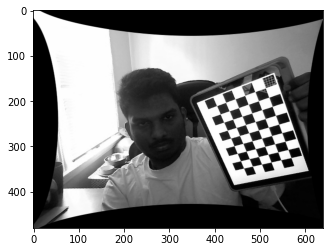

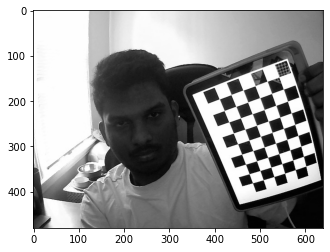

In [83]:
plt.imshow(dstR)
plt.show()
plt.imshow(imgR)
plt.show()

In [84]:
x,y,w,h = roiR2
distR_crop = dstR[y:y+h, x:x+w]

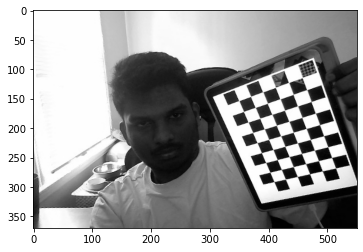

In [85]:
plt.imshow(distR_crop)
plt.show()

In [74]:
distR.shape

(1, 5)